# Final Project

In [1]:
# 移除不必要的警告
import warnings
warnings.filterwarnings('ignore')

### 獲取歷史資料

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print(tf.config.experimental.set_visible_devices)
print('GPU:', tf.config.list_physical_devices('GPU'))
print('CPU:', tf.config.list_physical_devices(device_type='CPU'))
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available()) # 输出可用的GPU数量
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) # 查询GPU设备

2023-07-14 17:01:02.412387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 17:01:02.540222: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-14 17:01:02.540241: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-14 17:01:03.140482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

2.11.0

<function set_visible_devices at 0x7f7a757bf440>
GPU: []
CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False
Num GPUs Available:  0


2023-07-14 17:01:04.000255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 17:01:09.072334: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-14 17:01:09.072367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fred-finlab): /proc/driver/nvidia/version does not exist


In [3]:
from finlab.data import Data
#from finlab.ml import fundamental_features
#fdf = fundamental_features()

data = Data()

close = data.get("收盤價")
open_ = data.get("開盤價")
high = data.get("最高價")
low = data.get("最低價")
vol = data.get("成交股數")

PB = data.get("股價淨值比")
pe = data.get("本益比")
DY = data.get("殖利率(%)")

#bi = data.get("營業利益")


#close = data.get_adj("收盤價").round(2)

#財務指標
rev = data.get("當月營收")
l_rev = data.get("去年當月營收")

#t123 = data.get('土地')

#bargin_i=data.get("投信買賣超股數")/data.get("成交股數")
#bargin_f=data.get("外資自營商買賣超股數")/data.get("成交股數")
#bargin_s=data.get("自營商買賣超股數(自行買賣)")/data.get("成交股數")
#

vol=data.get('成交股數')/1000
vol_ma5=vol.rolling(5).mean()

rev.index = rev.index.shift(5, "d")         #每月頻率
#周頻率

### 計算features

In [4]:
#MFI  = data.talib("MFI")
##MFI.tail()
#ub,mb,lb =data.talib("BBANDS")

#### 營收相關

In [5]:
##############################################　　　自己加入的　　　##############################################
import pandas as pd
import numpy as np

from finlab.__init__ import talib_all_stock
from talib import abstract

In [6]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min() 
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

#def yoy(n):
#    return (rev.shift(n) / rev.shift(12+n)) -
def yoy(n):
    denominator = rev.shift(12 + n)
    result = rev.shift(n) / denominator - 1
    result[denominator < 0] = 0  # 如果分母为负，将对应的结果设置为0
    return result

def delta_yoy(n):
    yoy_current = yoy(n)
    yoy_previous = yoy(n + 1)
    delta = yoy_current - yoy_previous
    return delta


# 均線
def ma(n):
    return close.rolling(n).mean()

# 標準差
def std(n):
    return close.rolling(n).std()

# 相對強弱指標（RSI）
def rsi(n):
    diff = close.diff()
    up = diff.where(diff > 0, 0)
    down = -diff.where(diff < 0, 0)
    avg_gain = up.rolling(n).mean()
    avg_loss = down.rolling(n).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 隨機指標（KD）
def kd(n):
    l = close.rolling(n).min()
    h = close.rolling(n).max()
    rsv = (close - l) / (h - l)
    k = rsv.rolling(3).mean()
    d = k.rolling(3).mean()
    return k - d

# 量能指標（OBV）
def obv():
    obv = pd.Series(0, index=close.index)
    obv[close > close.shift()] = vol[close > close.shift()]
    obv[close < close.shift()] = -vol[close < close.shift()]
    obv = obv.cumsum()
    return obv

def oscillator(n):
    return (close - close.rolling(n).mean()) / close.rolling(n).std()

def variance(n):
    return close.rolling(n).var()

In [7]:
def atr(n):
    tr = high - low
    tr = tr.fillna(0)  # 处理缺失值，将NaN替换为0
    atr = tr.rolling(n, min_periods=1).mean()
    return atr
    
def willr(n):
    highest_high = high.rolling(n, min_periods=1).max()
    lowest_low = low.rolling(n, min_periods=1).min()
    willr = (highest_high - close) / (highest_high - lowest_low) * -100
    return willr

def cci(n):
    typical_price = (high + low + close) / 3
    mean_typical_price = typical_price.rolling(n, min_periods=1).mean()
    mean_deviation = (typical_price - mean_typical_price).abs().rolling(n, min_periods=1).mean()
    cci = (typical_price - mean_typical_price) / (0.015 * mean_deviation)
    return cci

def linearreg_slope(n):
    slope = (close - close.shift(n)) / n
    return slope

def cdp(n):
    typical_price = (high + low + close) / 3
    pivot_point = (high + low + close) / 3
    previous_day_high = high.shift(1)
    previous_day_low = low.shift(1)
    
    hlr = pivot_point - previous_day_low
    hhr = previous_day_high - pivot_point
    
    cdp = (pivot_point + previous_day_high + previous_day_low + close) / 4
    ah = cdp + hhr
    nh = cdp * 2 - previous_day_low
    nl = cdp * 2 - previous_day_high
    al = cdp - hlr
    
    return cdp, ah, nh, nl, al
    
def tsf(n):
    forecast_period = n
    forecast = close.rolling(n).apply(lambda x: np.polyfit(np.arange(len(x)), x, deg=1)[1] + np.polyfit(np.arange(len(x)), x, deg=1)[0] * len(x))
    return forecast.shift(-forecast_period) / close

def adx(n):
    true_range = high - low
    true_range = true_range.fillna(0)
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    plus_dm = plus_dm.rolling(n).sum()
    minus_dm = minus_dm.abs().rolling(n).sum()
    
    tr_sum = true_range.rolling(n).sum()
    tr_sum[tr_sum == 0] = 0.0001
    
    plus_di = (plus_dm / tr_sum) * 100
    minus_di = (minus_dm / tr_sum) * 100
    
    dx = ((plus_di - minus_di).abs() / (plus_di + minus_di).abs()) * 100
    adx = dx.rolling(n).mean()
    
    return adx


def adxr(n):
    adx_value = adx(n)  # 先計算ADX值
    adxr = adx_value.rolling(n).mean()  # 計算ADX值的平均值
    return adxr

In [8]:
features = {
#    'mom{}'.format(n): mom(n) for n in range(1, 10)
}

features.update({
    'bias_{}'.format(n): bias(n) for n in [5, 10, 20, 60, 120, 240]
})

features.update({
    'acc_{}'.format(n): acc(n) for n in [5, 10, 20, 60, 120, 240]
})

features.update({
    'rsv_{}'.format(n): rsv(n) for n in [5, 10, 20, 60, 120, 240]
})

#features.update({
#    'PB': PB,
#    'PE': pe,
#    'DY': DY
#})

features.update({
    'yoy_{}'.format(n): yoy(n) for n in range(0, 5)
})

features.update({
    'delta_yoy_{}'.format(n): delta_yoy(n) for n in range(0, 5)
})

features.update({
    'atr_{}'.format(n): atr(n) for n in [10, 14, 20]
})

features.update({
    'willr_{}'.format(n): willr(n) for n in [14, 20, 30]
})

#features.update({
#    'cci_{}'.format(n): cci(n) for n in [20, 30, 40]
#})
features.update({
    'linearreg_slope_{}'.format(n): linearreg_slope(n) for n in [14, 28, 56, 112, 224]
})



#features.update({
#    'ma{}'.format(n): ma(n) for n in [5, 10, 20, 60, 120, 240]
#})



#
#
#features.update({
#    'obv': obv()
#})
#
#features.update({
#    'tsf_{}'.format(n): tsf(n) for n in [14, 20, 30]
#})
#
features.update({
    'kd{}'.format(n): kd(n) for n in [5, 10, 20, 60, 120, 240]
})

features.update({
    'adxr_{}'.format(n): adxr(n) for n in [14, 20, 30]
})


In [9]:
##def yoy(n):
##    if rev.shift(n) < 0:
##        return rev.shift(n)
##    else :
##        return (rev.shift(n) / rev.shift(12+n)) -1
##
##yoy(1)

In [10]:
#bi(60).dropna(how='all')

兩個feature結合[[連結網址]](https://hahow.in/courses/5b9d3a6dca498a001e917383/discussions/5d18b63eac23d80020ae4ce7)

---
```python
from finlab import ml
from finlab.data import Data

data = Data()
rsi = data.talib("RSI")

dataset = ml.fundamental_features()
ml.add_feature(dataset, 'RSI', rsi)
```

In [11]:
#dataset

#### 財報指標

In [12]:
#from finlab.ml import fundamental_features
#dataset_fundamental = fundamental_features()

In [13]:
#dataset_fundamental

#### 技術指標

加入其他features
* http://finlabcourse.imotor.com/viewthread.php?tid=660&extra=page%3D1

```python
from finlab import ml
from finlab.data import Data

data = Data()
rsi = data.talib("RSI")

dataset = ml.fundamental_features()
ml.add_feature(dataset, 'RSI', rsi)
```

#### 組合dataset

In [14]:
import pandas as pd

#### 確認各指標清單

In [15]:
#t1 = data.talib("NATR",timeperiod=14)
#t1.to_csv('myfile.csv')

### 製作dataset

##### 設定買賣頻率

In [16]:
#rev.index = rev.index.tz_localize("Asia/Taipei")
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-10-15', '2022-11-15', '2022-12-15', '2023-01-15',
               '2023-02-15', '2023-03-15', '2023-04-15', '2023-05-15',
               '2023-06-15', '2023-07-15'],
              dtype='datetime64[ns]', name='date', length=222, freq=None)

#### 將dataframe 組裝起來

In [17]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [18]:
for name, f in features.items():
    features[name] = f.unstack()

In [19]:
import pandas as pd
dataset = pd.DataFrame(features)

In [20]:
#我要把金融股拿掉 所以把28開頭全去掉
dataset = dataset[~dataset.index.get_level_values('stock_id').str.startswith('28')]

##### 裝自己要的

In [21]:
from finlab import ml

In [22]:
#from finlab import ml
#from finlab.data import Data

upper, middle, lower = data.talib("BBANDS", amount=0)
bband =  ((close -(upper+lower)/2) / (upper-lower)/2 )
ml.add_feature(dataset, 'BBANDS', bband)

#real = data.talib("TSF") #时间序列预测
#real = real /close
#ml.add_feature(dataset, 'TSF', real /close)
#
real = data.talib("LINEARREG_ANGLE") #线性回归的角度
ml.add_feature(dataset, 'LINEARREG_ANGLE', real)

real = data.talib("DX") #DX ：动向指标或趋向指标
ml.add_feature(dataset, 'DX', real)

real = data.talib("BOP") #BOP ：均势指标
ml.add_feature(dataset, 'BOP', real)

real = data.talib("CORREL") #CORREL ：皮尔逊相关系数
ml.add_feature(dataset, 'CORREL', real)

real = ""

In [23]:
#dataset=""

In [24]:
feature_names = list(dataset.columns)

In [25]:
feature_names

['bias_5',
 'bias_10',
 'bias_20',
 'bias_60',
 'bias_120',
 'bias_240',
 'acc_5',
 'acc_10',
 'acc_20',
 'acc_60',
 'acc_120',
 'acc_240',
 'rsv_5',
 'rsv_10',
 'rsv_20',
 'rsv_60',
 'rsv_120',
 'rsv_240',
 'yoy_0',
 'yoy_1',
 'yoy_2',
 'yoy_3',
 'yoy_4',
 'delta_yoy_0',
 'delta_yoy_1',
 'delta_yoy_2',
 'delta_yoy_3',
 'delta_yoy_4',
 'atr_10',
 'atr_14',
 'atr_20',
 'willr_14',
 'willr_20',
 'willr_30',
 'linearreg_slope_14',
 'linearreg_slope_28',
 'linearreg_slope_56',
 'linearreg_slope_112',
 'linearreg_slope_224',
 'kd5',
 'kd10',
 'kd20',
 'kd60',
 'kd120',
 'kd240',
 'adxr_14',
 'adxr_20',
 'adxr_30',
 'BBANDS',
 'LINEARREG_ANGLE',
 'DX',
 'BOP',
 'CORREL']

In [26]:
#feature_names

##### 下面的feature **不要** 列入訓練

In [27]:
股本 = data.get('股本合計').reindex(close.index, method='ffill')
市值 = 股本 * close / 10 * 1000
#t1['2330'].dropna()
ml.add_feature(dataset, '市值', 市值)

In [28]:
ml.add_feature(dataset, 'vol_ma5', vol_ma5)

#dataset

In [29]:
##############################################　　　自己加入的　　　##############################################
dataset.index = dataset.index.set_names(['stock_id','date'], level=[0,1])


#dataset.index.levels[1].name = 'date'
#dataset.index.levels[0].name = 'stock_id'

#因為你pandas更新到新版了
## profit.index.levels[0].name = 'year'
## profit.index.levels[1].name = 'month'
#這兩行的語法被棄用，請改成
#profit.index=profit.index.set_names('year', level=0)
#profit.index=profit.index.set_names('month', level=1)
#or profit.index=profit.index.set_names(['year','month'], level=[0,1])
#直接一行
#就可以了

In [30]:
#list(dataset_fundamental.index)

In [31]:
#dataset_fundamental.reindex(dataset.index).dropna()

data[組合](https://hahow.in/courses/5b9d3a6dca498a001e917383/discussions/5d18b63eac23d80020ae4ce7)
```python
new_df = pd.concat([dataset_fundamental['R406_經常利益成長率'],dataset],axis=1).dropna(how='any')
```

In [32]:
#new_df = pd.concat([dataset_fundamental,dataset],axis=1).dropna(how='any')
#dataset1 = new_df.fillna(method='ffill')#[(new_df.index.get_level_values('stock_id')=='2330')]
##dataset = dataset1

In [33]:
#feature_names=list(dataset1.columns)
#feature_names

### 新增 label(績效/排名)
 - 定義一下要比績效還是要比排名

In [34]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

In [35]:
#profit(return) rank
predi_target = 'rank'

### 刪除太大太小的歷史資料

In [36]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset , feature_names , thresh=0.01)

print(dataset_drop_extreme_case.shape)

##(436774, 25)
##(388157, 25)

(449106, 57)
(356726, 57)


In [37]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [38]:
#dataset_drop_extreme_case.index.get_level_values("date")

In [39]:
##################################################################################################################
##############################################　　　自己加入的　　　##############################################
##################################################################################################################

dataset_dropna.index = pd.to_datetime(dataset_dropna.index)
dataset_dropna = dataset_dropna.sort_index()

#修復＜class ‘numpy.ndarray‘＞　https://blog.csdn.net/lxbin/article/details/114005757

## Split Train Test dataset

In [40]:
# 計算要分割的索引位置
split_index = int(len(dataset_dropna) * 0.85)

# 分割資料集
dataset_train = dataset_dropna.iloc[:split_index]
dataset_test = dataset_dropna.iloc[split_index:]

In [41]:
dataset_test

,stock_id,bias_5,bias_10,bias_20,bias_60,bias_120,bias_240,acc_5,acc_10,acc_20,...,adxr_30,BBANDS,LINEARREG_ANGLE,DX,BOP,CORREL,市值,vol_ma5,return,rank
date,,,,,,,,,,,,,,,,,,,,,
2022-01-15,6506,0.961437,0.948905,0.945823,0.960338,1.003676,1.047269,1.011858,1.053333,1.048913,...,19.539787,-0.228411,-4.229669,21.146471,-0.750000,0.822237,1.498967e+09,211.8684,1.024390,0.739965
2022-01-15,1459,0.998363,0.979133,0.962335,0.946103,0.966528,1.001831,0.974052,1.023904,0.996139,...,27.974510,-0.036860,-3.791090,16.861694,0.285714,0.955541,4.375273e+09,277.7948,0.959350,0.178883
2022-01-15,5538,1.018168,1.029074,1.024079,1.070469,1.168084,1.228053,0.952381,0.990706,1.012230,...,47.781671,0.143592,2.252892,13.795519,0.357143,0.760034,1.082474e+10,312.2922,1.045045,0.842932
2022-01-15,4935,0.987326,0.964945,0.965962,0.974806,0.964427,0.858915,1.000622,1.062740,1.006427,...,17.286442,-0.143009,-22.201936,5.613857,-0.625000,0.974884,1.020000e+10,202.3350,0.973214,0.269924
2022-01-15,8462,0.993098,0.982177,0.967501,0.933950,0.924835,0.884034,0.996226,1.022642,1.000000,...,16.587186,-0.153093,-31.102442,25.951272,-0.500000,0.931781,1.003085e+10,60.0122,1.035294,0.800465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15,1103,0.988928,0.980294,0.982254,1.005930,1.057755,1.085810,1.025189,1.028205,1.003891,...,20.946060,-0.171875,-1.152057,5.928374,-0.500000,0.927452,1.522444e+10,396.4582,1.066158,0.587177
2023-05-15,6176,0.996488,0.999120,1.004425,1.039219,1.067005,1.117671,0.997792,1.002217,1.025172,...,28.355443,-0.133631,7.883139,49.739801,-0.333333,0.683904,5.278060e+10,1231.1882,1.105263,0.734814
2023-05-15,2912,1.003847,1.013955,1.036943,1.056669,1.062045,1.052970,1.024215,0.969534,0.979223,...,23.585039,0.086275,57.013496,60.981905,0.800000,0.951460,2.983716e+11,1107.0124,0.993068,0.139483


In [42]:
train = dataset_train[feature_names] , dataset_train['return'] > 1.00
test = dataset_test[feature_names] , dataset_test['return'] > 1.00

### 機器學習
 - 目前只有三個，技術指標也要再增加一下feature_names

In [43]:
#feature_names = feature_names1

In [44]:
#dataset_train.index

#### keras

In [45]:
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.BatchNormalization(input_shape=(len(feature_names),)))
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#model.compile(loss='mean_squared_error',
#              optimizer="adam",)

print('----------start fitting----------')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

get_best_model = keras.callbacks.ModelCheckpoint(
    filepath='./best_model/v1_03.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    save_best_only=True)

history = model.fit(dataset_train[feature_names], dataset_train[predi_target],
                    batch_size=1000,
                    epochs=1000,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[es, get_best_model] #es, get_best_model
                    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 53)               212       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               5400      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                        

----------start fitting----------
Epoch 1/1000
68/79 [========================>.....] - ETA: 0s - loss: 0.8099 - accuracy: 1.9118e-04
Epoch 1: val_loss improved from inf to 0.69752, saving model to ./best_model/v1_03.h5
79/79 [==============================] - 1s 6ms/step - loss: 0.7994 - accuracy: 1.7906e-04 - val_loss: 0.6975 - val_accuracy: 0.0000e+00
Epoch 2/1000
71/79 [=========================>....] - ETA: 0s - loss: 0.7147 - accuracy: 1.1268e-04
Epoch 2: val_loss improved from 0.69752 to 0.69397, saving model to ./best_model/v1_03.h5
79/79 [==============================] - 0s 4ms/step - loss: 0.7138 - accuracy: 1.5348e-04 - val_loss: 0.6940 - val_accuracy: 1.1510e-04
Epoch 3/1000
71/79 [=========================>....] - ETA: 0s - loss: 0.7010 - accuracy: 1.1268e-04
Epoch 3: val_loss improved from 0.69397 to 0.69257, saving model to ./best_model/v1_03.h5
79/79 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 1.2790e-04 - val_loss: 0.6926 - val_accuracy: 

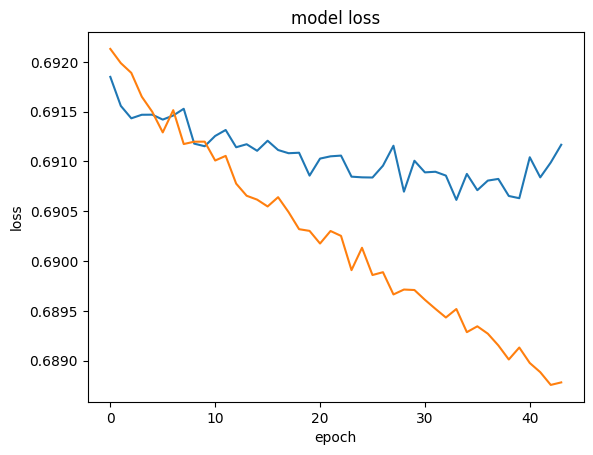

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['val_loss'][10:])
plt.plot(history.history['loss'][10:])

In [47]:
#t1 = model.predict(dataset[feature_names].astype(float))
#t2 = pd.Series(t1.swapaxes(0,1)[0], dataset.index)
#t2

In [48]:
#import numpy as np
#from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.constraints import MaxNorm
#
## 將 DataFrame 和 Series 轉換為 NumPy 數組
#X_train = dataset_train[feature_names].to_numpy()
#y_train = dataset_train[predi_target].to_numpy()
#
## 定義建立模型的函數
#def create_model(kernel_constraint):
#    model = keras.models.Sequential()
#    model.add(layers.BatchNormalization(input_shape=(X_train.shape[1],)))
#    model.add(layers.Dense(200, activation='relu',
#                      kernel_initializer=initializers.he_normal(seed=0),
#                      kernel_constraint=MaxNorm(kernel_constraint)))
#    model.add(layers.Dense(1, activation='sigmoid'))
#    optimizer = keras.optimizers.Adam(learning_rate=0.001)
#    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#    return model
#
## 使用 KerasClassifier 包裝模型
#keras_classifier = KerasClassifier(build_fn=create_model)
#
## 定義網格搜尋的參數範圍
#param_grid = {
#    'kernel_constraint': [1, 2, 3, 0.1, 10, 0.01 ,100]  # 調整 kernel_constraint 的值
#}
#
## 建立網格搜尋模型
#grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=5)
#
## 執行網格搜尋
#grid_result = grid_search.fit(X_train, y_train)
#
## 印出最佳的參數組合和分數
#print("Best Score:", grid_result.best_score_)
#print("Best Params:", grid_result.best_params_)
#

In [49]:
#type(dataset_train[feature_names])

##### 結果

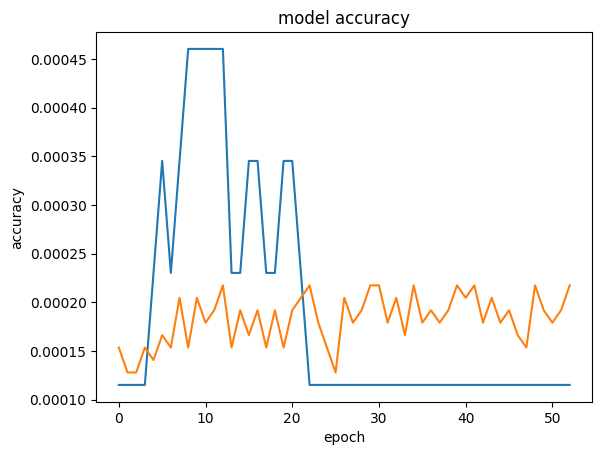

In [50]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['val_accuracy'][1:])
plt.plot(history.history['accuracy'][1:])

#### lightgbm Model

In [51]:
##############################################　　　自己加入的　　　##############################################
import lightgbm as lgb

cf = lgb.LGBMRegressor(n_estimators=5000)

print('---cf.fit---')
print(cf.fit(*train))
print('---cf.score---')
print(cf.score(*test))
print('---predict---')
print(cf.predict(test[0]))

---cf.fit---
LGBMRegressor(n_estimators=5000)
---cf.score---
-0.10697785176360419
---predict---
[0.41212111 0.2806317  0.30592121 ... 0.35865288 0.44234585 0.43803825]


##### 參數優化_1110

In [52]:
#import lightgbm

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [test],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test = {
            'num_leaves': sp_randint(10, 100),
            'min_child_samples': sp_randint(50, 200),
            'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'subsample': sp_uniform(loc=0.1, scale=0.9),
            'colsample_bytree': sp_uniform(loc=0.2, scale=0.8),
            'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
            'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }
            

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 200

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000) #LGBMClassifier
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [53]:
gs.fit(*train, **fit_params)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid's auc: 0.538042
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[67]	valid's auc: 0.52241
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.520213
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid's auc: 0.557083
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid's auc: 0.527287
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid's auc: 0.515181
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best ite

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(metric='None', n_estimators=5000,
                                            n_jobs=4, random_state=314),
                   n_iter=200,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f793bba9e10>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f793bba9910>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f793bba9810>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
                     

In [54]:
print(gs.best_score_)
gs.best_estimator_

0.5450870583557271


LGBMClassifier(colsample_bytree=0.3077875915585547, metric='None',
               min_child_samples=176, min_child_weight=1, n_estimators=5000,
               n_jobs=4, num_leaves=15, random_state=314, reg_alpha=0,
               reg_lambda=10, subsample=0.5457856871125956)

In [55]:
#
#gs.best_estimator_
#LGBMClassifier(colsample_bytree=0.6433117836032942, metric='None',
#               min_child_samples=224, min_child_weight=1e-05, n_estimators=5000,
#               n_jobs=4, num_leaves=20, random_state=314, reg_alpha=10,
#               reg_lambda=10, subsample=0.8945613420997809)

In [56]:
##cf = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
##               colsample_bytree=0.4467801334566121, importance_type='split',
##               learning_rate=0.1, max_depth=-1, metric='None',
##               min_child_samples=107, min_child_weight=1, min_split_gain=0.0,
##               n_estimators=5000, n_jobs=4, num_leaves=43, objective=None,
##               random_state=314, reg_alpha=10, reg_lambda=100, silent=True,
##               subsample=0.40294551048668437, subsample_for_bin=200000,
##               subsample_freq=0)
##
##
##cf.fit(dataset_train[feature_names],dataset_train['return'] > 1.05, **fit_params)
##cf.score(dataset_test[feature_names],dataset_test['return'] > 1.05)
##下面那行調整中

In [57]:
##原本的上面那行
cf = lgb.LGBMClassifier(colsample_bytree=0.3019355798761505, metric='None',
               min_child_samples=158, min_child_weight=100.0, n_estimators=5000,
               n_jobs=4, num_leaves=65, random_state=314, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.15583630368037524)

cf.fit(dataset_train[feature_names],dataset_train['return'] > 1.0, **fit_params)
cf.score(dataset_test[feature_names],dataset_test['return'] > 1.0)

#-0.0022746308430701134
#0.052801756206640516

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid's auc: 0.525378


0.5295153610332007

<AxesSubplot:xlabel='Value', ylabel='Feature'>

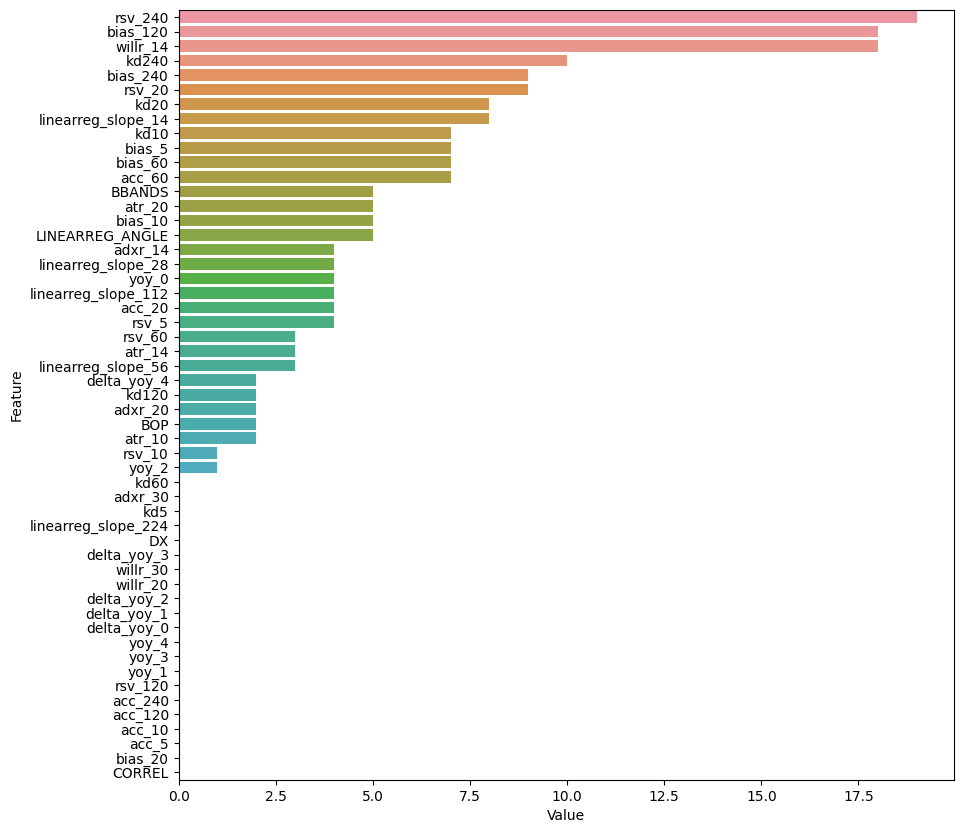

In [58]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp)

In [59]:
dataset['return']['0050'].index

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-10-15', '2022-11-15', '2022-12-15', '2023-01-15',
               '2023-02-15', '2023-03-15', '2023-04-15', '2023-05-15',
               '2023-06-15', '2023-07-15'],
              dtype='datetime64[ns]', name='date', length=222, freq=None)

In [60]:
#print(cf.fit(*train))

In [61]:
#import lightgbm as lgb
#gbm = lgb.LGBMClassifier(n_estimators=100, random_state=5, learning_rate=0.01)
#gbm.fit(dataset_train[feature_names], dataset_train['return'] > 1)

In [62]:
#import tqdm
#
#n = 3
#
#X = []
#y = []
#indexes = []
#dataset_scaled_x = dataset_scaled[feature_names]
#
#for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
#    X.append(dataset_scaled_x.iloc[i:i+n].values)
#    y.append(dataset_scaled['return'].iloc[i+n-1])
#    indexes.append(dataset_scaled.index[i+n-1])
##dataset_scaled.head()

In [63]:
#import numpy as np
#X = np.array(X)
#y = np.array(y)

In [64]:
##import lightgbm as lgb
#cf = lgb.LGBMRegressor(colsample_bytree=0.7740467183023685, metric='None',
#               min_child_samples=395, min_child_weight=0.01, n_estimators=5000,
#               n_jobs=4, num_leaves=9, random_state=314, reg_alpha=5,
#               reg_lambda=10, subsample=0.4643892520208455)
#    
#cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

#### Random Forest Model

In [65]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train[predi_target])  

RandomForestRegressor()

##### 參數優化_1110

In [66]:
#from scipy.stats import randint as sp_randint 
#from sklearn.model_selection import RandomizedSearchCV 
## build a classifier 
#cf2 = RandomForestRegressor(n_estimators=100) 
## specify parameters and distributions to sample from 
#param_dist = {"max_depth": [3, None], 
#              "max_features": sp_randint(1, 11), 
#              "min_samples_split": sp_randint(2, 11), 
#              "min_samples_leaf": sp_randint(1, 11), 
#              "bootstrap": [True, False], 
#              "criterion": ["mse", "mae"]} 
## run randomized search 
#n_iter_search = 20 
#rs = RandomizedSearchCV(cf2, param_distributions=param_dist, 
#                                   n_iter=n_iter_search) 

In [67]:
#rs.fit(dataset_train[features], dataset_train['return'] >1)

##### Split Train Test dataset

<AxesSubplot:xlabel='Value', ylabel='Feature'>

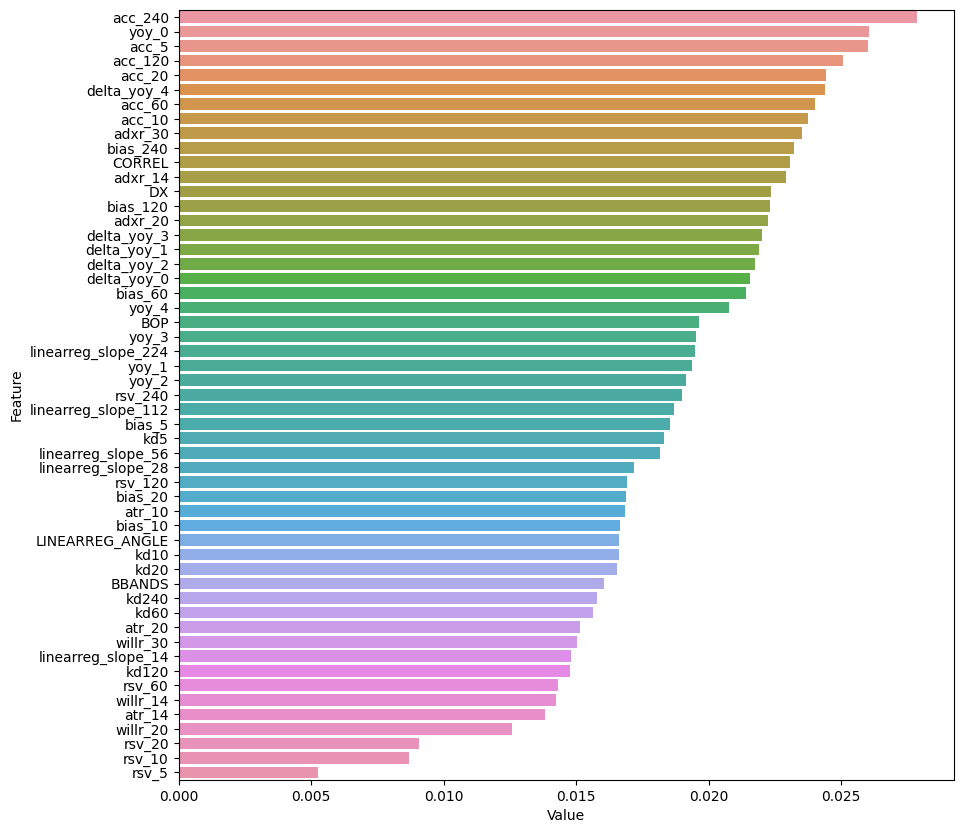

In [68]:
feature_imp = pd.DataFrame(zip(cf2.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp)

In [69]:
#select = dataset.index.get_level_values('date') < '2022-03'
#dataset_train = dataset[select]
#dataset_test = dataset[~select]

### Ensemble learning

In [70]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = cf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = cf2.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

 143/5964 [..............................] - ETA: 4s

2023-07-14 17:19:10.226560: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 80912344 exceeds 10% of free system memory.


5964/5964 [==============================] - 4s 685us/step


In [71]:
model.predict(dataset_drop[feature_names].astype(float))

 213/5964 [>.............................] - ETA: 4s

2023-07-14 17:19:22.059251: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 80912344 exceeds 10% of free system memory.


5964/5964 [==============================] - 4s 694us/step


array([[0.47665426],
       [0.4207443 ],
       [0.50259286],
       ...,
       [0.5307471 ],
       [0.50746214],
       [0.509649  ]], dtype=float32)

## backtest

## 把量加進來做篩選
 * https://hahow.in/courses/5b9d3a6dca498a001e917383/shapeussions/60c96f5b018697e8a6131cbc

In [72]:
#把量加進來
vol=data.get('成交股數')/1000
vol_ma5=vol.rolling(5).mean()

vol_filter=vol_ma5>1000
vol_filter=vol_filter[vol_filter].fillna(0)
#vol_filter
t1 = vol_filter

In [73]:
#condition2

In [74]:
vol_filter = t1.reindex(every_month, method='ffill')#.loc['2010-02-15']
#vol_filter.loc['2010-02-15']

In [75]:
#t1 = vol_ma5.iloc[-1].dropna()
#t1.to_csv('./tmp/132.csv')
#t1.hist(bins=10)

In [76]:
#dataset_cleaned.dropna()

In [77]:
#dataset_cleaned

In [78]:
len(dataset_drop[dataset_drop['stock_id'] == '1101']['result1']['2020':].fillna(0))

41

<AxesSubplot:>

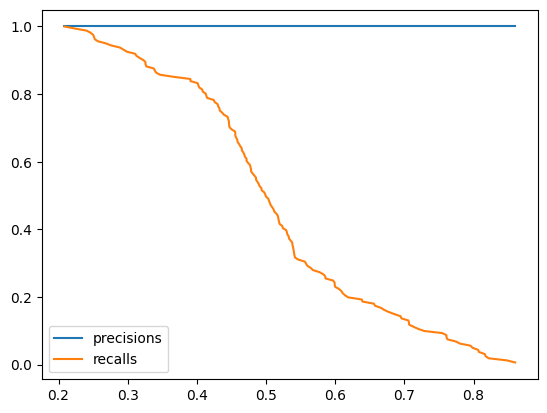

In [79]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# 替換NaN值為0
dataset_cleaned = dataset['return']['6279']['2010':].dropna()
dataset_drop_cleaned = dataset_drop[dataset_drop['stock_id'] == '6279']['result3']['2010':]

# 使用 precision_recall_curve 計算精確度和召回率
precisions, recalls, thresholds = precision_recall_curve(dataset_cleaned > 0, dataset_drop_cleaned)

# 繪製精確度-召回率曲線
pd.DataFrame({
    'precisions': precisions[:-1],
    'recalls': recalls[:-1],
}, index=thresholds).plot()


In [80]:
#positive_data = predi_target[predi_target > 0]
#positive_data.hist()

In [81]:
#市值
#t1 = (predi_target >= predi_target.nlargest(20).iloc[-1]) * condition_Filter_v2.astype(float)()
dataset_time['result1'] 

NameError: name 'dataset_time' is not defined

In [ ]:
import math
from tqdm import tqdm

vol = 500
test_period = '2022-08'

dates = sorted(list(set(dataset_drop.index)))

rs = []
rs_v1 = []
rs_v2 = []
rs_v3 = []

for d in tqdm(dates):
    #print(d)
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time , feature_names , thresh=0.01)
    
    #print(dataset_time)
    
    predi_target = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    #predi_target = predi_target * (dataset_time['vol_ma5'] >vol).astype(float)
            ###

    
    condition1 = dataset_time['vol_ma5'] > vol
    condition_Filter_v1 = condition1
    predi_target_v1 = predi_target * condition_Filter_v1.astype(float)
    
    condition2 = (1e9 < dataset_time['市值']) < 1e10
    
    condition_Filter_v2 =  condition1 + condition2
    predi_target_v2 = predi_target * condition_Filter_v2.astype(float)
    
    condition_P = (predi_target >= predi_target.nlargest(20).iloc[-1])
    condition_v1 = (predi_target_v1 >= predi_target_v1.nlargest(20).iloc[-1])
    condition_v2 = (predi_target_v2 >= predi_target_v2.nlargest(20).iloc[-1])
    
    predi_target = predi_target * (dataset_time['vol_ma5'] >vol).astype(float)
    condition_v3 = (predi_target >= predi_target.nlargest(20).iloc[-1]) & condition_Filter_v2 #.astype(float)
    
    #print(vol_filter.loc[d])
    #print(condition)
    
    r = dataset_time['return'][condition_P].mean()
    rs.append(r * (1-3/1000-1.425/1000*2*0.6))
    
    r_v1 = dataset_time['return'][condition_v1].mean()
    rs_v1.append(r_v1 * (1-3/1000-1.425/1000*2*0.6))    
    
    r_v2 = dataset_time['return'][condition_v2].mean()
    rs_v2.append(r_v2 * (1-3/1000-1.425/1000*2*0.6))    
    test2 = r_v2

    r_v3 = dataset_time['return'][condition_v3].mean()
    rs_v3.append(r_v3 * (1-3/1000-1.425/1000*2*0.6))    
        
rs = pd.Series(rs, index=dates)[test_period:].cumprod()
rs_v1 = pd.Series(rs_v1, index=dates)[test_period:].cumprod() #*
rs_v2 = pd.Series(rs_v2, index=dates)[test_period:].cumprod() #*
rs_v3 = pd.Series(rs_v3, index=dates)[test_period:].cumprod() #*

s0050 = close['0050'][test_period:]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'),
              'nn strategy return_V1(vol>100)':rs_v1.reindex(s0050.index, method='ffill'),
              #'nn strategy return_V2(vol+market cap)':rs_v2.reindex(s0050.index, method='ffill'),
              #'nn strategy return_V3(vol+market cap)':rs_v3.reindex(s0050.index, method='ffill'),
              '0050 return':s0050/s0050[0]
             }).plot()



#import winsound
#frequency = 2000
#duration = 100
#winsound.Beep(frequency, duration)

In [ ]:
##上漲的信心程度分布度
dataset_drop['result1'].hist()
dataset_drop['result3'].hist()
#dataset_drop['result2'].hist()


In [ ]:
#testy = pd.Series(test2, index=dates).cumprod()
#testy

In [ ]:
import pickle
pickle.dump(testy, open('Preturn_history.pkl', 'wb'))

In [ ]:
#import pickle
#
#return_history_1026 = pd.Series(rs, index=dates)['2021':].cumprod()
##eq = (gain[hold == 1].mean(axis=1)).fillna(1).cumprod()
#
#pickle.dump(rs, open('return_history_1026.pkl', 'wb'))

In [ ]:
#import pyfolio as pf
#import pandas as pd
#
#close.index = close.index.tz_localize("Asia/Taipei")
##pf.create_returns_tear_sheet(close['0050'].pct_change())
#
## 得到 上一個單元的 回測結果
#ret = pickle.load(open("return_history_1026.pkl", "rb"))
#
## 將回測報酬率取出來
#ret = ret.pct_change().dropna()
#ret.index = pd.to_datetime(ret.index).tz_localize('Asia/Taipei')
#
## 利用pyfolio 比較報酬率
#pf.create_returns_tear_sheet(ret, benchmark_rets=close['0050'].pct_change())

### 當月持股狀況

In [ ]:
# get the latest dataset
last_date = dataset.index.levels[1].max()#"2022-10-15"
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset, feature_names , thresh=0.01)
t1 = last_dataset

# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)


# calculate score

predi_target = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']

#
##predi_target = predi_target * vol_filter.iloc[-1] #******加上量的濾網


predi_target = predi_target * (last_dataset['vol_ma5'] >vol).astype(float)  #排除平均成交量小於MA1000張
#predi_target = predi_target * (last_dataset['市值'] < 1e10).astype(float)   #排除市值小於100億以下的股票

condition0 = (predi_target >= predi_target.nlargest(20).iloc[-1])
condition1 = last_dataset['vol_ma5'] >vol
condition2 = last_dataset['市值'] < 1e10

condition = condition0 & condition1 #& condition2

#vol_filter

# plot rank distribution
predi_target[predi_target!=0].hist(bins=20)


# show the best 20 stocks
slist1 = predi_target[condition].reset_index()['stock_id']

#https://keras-cn.readthedocs.io/en/latest/models/model/

In [ ]:
last_date = dataset.index.levels[1].max()#"2022-10-15"
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()

In [ ]:
#rank.sort_values(ascending=False).head(20)

## 平均分配資產於股票之中

In [ ]:
close = data.get("收盤價")

money = 494111-1000
stock_prices = close[slist1].iloc[-1]

print("股票平分金額:" + str(money/20))

print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000


In [ ]:
last_dataset['市值'][slist1]

In [ ]:
last_dataset['vol_ma5'][slist1]

###################################################################################################
## 移動窗格最佳化
[有空來試試看連結](https://hahow.in/courses/5b9d3a6dca498a001e917383/discussions/61b4c90147843d0006cf2593)
###################################################################################################

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 創建Random Forest模型
random_forest = RandomForestClassifier(n_estimators=100)

# 使用訓練資料訓練模型
random_forest.fit(X_train, y_train)

# 使用測試資料評估模型
accuracy = random_forest.score(X_test, y_test)
print("Random Forest 模型的準確率：", accuracy)


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

def select(df):
    rank = df['pre']
    condition1 = (rank >= rank.nlargest(1).iloc[-1])
    return df['return'][condition1].mean() * (1-3/1000-1.425/1000*2*0.6)

end = 5
cf = lgb.LGBMRegressor(n_estimators=500)
train_time = ['2015','2016','2017','2018','2019']
s_time = ['2007','2008','2009','2010','2011']
test_time = ['2016','2017','2018','2019','2020']
store_mse = []

# List to store the predictions
predictions = []

for time in range(end):
    print('%d 次執行中'%(time))
    dataset_dropna2_train = dataset_copy.loc[s_time[time]:train_time[time]] #2007~ 2015   2008~2016   2009~2017  2010~2018  ....
    dataset_dropna2_test = dataset_copy.loc[test_time[time]:test_time[time]]#            2016                2017               2018              2019  .....
    
    cf.fit(dataset_dropna2_train[feature_names].astype(float), dataset_dropna2_train['rank'])
    
    predict = cf.predict(dataset_dropna2_test[feature_names])
    dataset_dropna2_test['pre'] = predict
    predictions.append(dataset_dropna2_test['pre'])  # Save the predictions
    
    dates = dataset_dropna2_test.index.get_level_values('date')
    b = dataset_dropna2_test.groupby(dates).apply(select).cumprod()
    s0050 = close['0050'][test_time[time]:test_time[time]]
    s0056 = close['0056'][test_time[time]:test_time[time]]
    pd.DataFrame({'Best 1 stocks return(include handling fee)': b.reindex(s0050.index, method='ffill'),
                  '0050': s0050/s0050[0], '0056': s0056/s0056[0]}).plot()
    plt.ylabel('return')


In [ ]:
def mystrategy(data):

    close = data.get("收盤價", 120)

    vol = data.get('成交股數', 120)
 

    condition1 = close.max() / close.min()

    rev = data.get("當月營收", 14)

    condition2 = (rev.iloc[-1] / rev.iloc[-13])

    condition3 = (rev.iloc[-2] / rev.iloc[-14])

    稅後淨利 = data.get('本期淨利（淨損）', 5)

    # 股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額，所以得把它們抓出來

    權益總計 = data.get('權益總計', 5)

    權益總額 = data.get('權益總額', 5)

    # 並且把它們合併起來

    權益總計.fillna(權益總額, inplace=True)

    roe = 稅後淨利 / 權益總計

    condition4 = roe.iloc[-1] / roe.iloc[-5]

    select_stock = (condition1.rank() + # 該數值越小越好

    condition2.rank(ascending=False) + # 該值越大越好 

    condition3.rank(ascending=False) + # 該值越大越好

    condition4.rank(ascending=False) # 該值越大越好 

    ).rank() <= 10
    
    df=select_stock[select_stock]
    vol=vol[df.index].iloc[-1]
    cond_vol=vol>(1000*1000)

    return cond_vol[cond_vol]


In [ ]:
stocks = mystrategy(data)
stocks

In [ ]:
    權益總計 = data.get('權益總計', 5)

    權益總額 = data.get('權益總額', 5)

    # 並且把它們合併起來

    權益總計.fillna(權益總額, inplace=True)

In [ ]:
權益總計

In [ ]:
close = data.get("收盤價", 120)
vol = data.get('成交股數', 120)
condition1 = close.max() / close.min()
rev = data.get("當月營收", 14)
condition2 = (rev.iloc[-1] / rev.iloc[-13])
condition3 = (rev.iloc[-2] / rev.iloc[-14])
稅後淨利 = data.get('本期淨利（淨損）', 5)
# 股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額，所以得把它們抓出來
權益總計 = data.get('權益總計', 5)
權益總額 = data.get('權益總額', 5)
# 並且把它們合併起來
權益總計.fillna(權益總額, inplace=True)
roe = 稅後淨利 / 權益總計
condition4 = roe.iloc[-1] / roe.iloc[-5]
select_stock = (condition1.rank() + # 該數值越小越好
condition2.rank(ascending=False) + # 該值越大越好 
condition3.rank(ascending=False) + # 該值越大越好
condition4.rank(ascending=False) # 該值越大越好 
).rank() <= 10
df=select_stock[select_stock]
vol=vol[df.index].iloc[-1]
cond_vol=vol>(1000*1000)


In [ ]:
condition4

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape = (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape =(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [ ]:
history = model.fit(
    dataset_train,  
    dataset_train > 1, 
    batch_size=2000, 
    epochs=10,
    validation_split=0.2, 
    callbacks=[get_best_model])


In [ ]:
####################################
dataset_B = dataset

In [ ]:
dataset.reset_index(inplace=True)
dataset = dataset.drop(columns=['stock_id']).set_index('date')
dataset

In [ ]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

In [ ]:
import tqdm

n = 3

X = []
y = []
indexes = []
dataset_scaled_x = dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
    X.append(dataset_scaled_x.iloc[i:i+n].values)
    y.append(dataset_scaled['return'].iloc[i+n-1])
    indexes.append(dataset_scaled.index[i+n-1])
#dataset_scaled.head()

import numpy as np
X = np.array(X)
y = np.array(y)
indexes = np.array(indexes)

In [ ]:
# from tensorflow.keras.engine.topology import Layer
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape = (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape =(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

from tensorflow import keras

input_shape = X[0].shape # 還沒有 X ，請自己試試看！（參考u22-lstm.ipynb）
SEQ_LEN = input_shape[0]

model = keras.models.Sequential()

model.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
#model.add(keras.layers.Dropout(0.8))
#model.add(keras.layers.BatchNormalization())
model.add(Attention(SEQ_LEN))
model.add(keras.layers.Dense(32, activation="relu"))
#model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Dense(1))
model.compile(optimizer=keras.optimizers.Adam(0.0005), loss='binary_crossentropy' , metrics = ['accuracy'])



In [ ]:
import datetime
X_train = X[indexes < datetime.datetime(2016, 1, 1)]
y_train = y[indexes < datetime.datetime(2016, 1, 1)]


get_best_model = keras.callbacks.ModelCheckpoint(
    filepath='./checkpoint_hw_4_1',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


history = model.fit(
    X_train,  
    y_train > 1, 
    batch_size=2000, 
    epochs=10,
    validation_split=0.2, 
    callbacks=[get_best_model])


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# u22-lstm 程式碼(evaluation and backtest)
model.load_weights("./checkpoint_hw_4_1")
ey = model.predict(X)
ey = pd.Series(ey.swapaxes(0,1)[0], index=indexes)
ey.plot()


In [ ]:
eq = close['0050']
returns = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.6)).rolling(10).sum() > 0
signal = signal.shift(1).fillna(False)

eq = (returns[signal]['2021':]).cumsum()
eq.plot()

In [ ]:
close['0050']